In [1]:
# Q sensitivity to P/T
# CTSM simulation vs CAMELS Obs

# Reference:
# Lehner, F., Wood, A. W., Vano, J. A., Lawrence, D. M., Clark, M. P., & Mankin, J. S. (2019).
# The potential to reduce uncertainty in regional runoff projections from climate models.
# Nature Climate Change, 9(12), 926–933. https://doi.org/10.1038/s41558-019-0639-x


import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, box
import geopandas as gpd
import os, scipy

import warnings
warnings.filterwarnings('ignore')

def Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10):

    # Sample data
    data = {'dQ':dQ, 'dP': dP, 'dT':dT}

    df = pd.DataFrame(data)
    df['dPdT'] = df['dP'] * df['dT']

    # Define independent variables (X) and dependent variable (y)
    X = df[['dP', 'dT', 'dPdT']]
    X = sm.add_constant(X)  # Adds a constant column for the intercept
    y = df['dQ']

    # Perform regression
    model = sm.OLS(y, X).fit()

    # get coefficients
    a = model.params['dP']
    b = model.params['dT']
    c = model.params['dPdT']

    # print(f"a (coefficient for dP) = {a}")
    # print(f"b (coefficient for dT) = {b}")
    # print(f"c (coefficient for dPdT) = {c}")

    # Get the confidence intervals
    conf_intervals = model.conf_int(alpha = conflevel)  # 10% significance level for 5-95% CIs

    # Extract the intervals for dP (a) and dT (b)
    a_interval = conf_intervals.loc['dP'].values
    b_interval = conf_intervals.loc['dT'].values
    c_interval = conf_intervals.loc['dPdT'].values

    # print("Confidence interval for a (dP):", a_interval)
    # print("Confidence interval for b (dT):", b_interval)
    # print("Confidence interval for c (dPdT):", c_interval)

    return a, b, c, a_interval, b_interval, c_interval


def load_and_fill_missing_dates_CAMELSforcing(file):
    df = pd.read_csv(file, skiprows=3, delim_whitespace=True)
    df = df.rename(columns={'Year':'year', 'Mnth':'month', 'Day':'day', 'Hr':'hour'})
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    df.set_index('date', inplace=True)
    date_range = pd.date_range(start='1980-01-01', end='2014-12-31', freq='D')
    df_reindexed = df.reindex(date_range)
    df_reset = df_reindexed.reset_index().rename(columns={'index': 'date'})
    
    return df_reset


def load_and_fill_missing_dates_CAMELSq(file_q):
    df_q = pd.read_csv(file_q, delim_whitespace=True, header=None)
    df_q.columns = ['name', 'year', 'month', 'day', 'Qobs', 'code']
    df_q['date'] = pd.to_datetime(df_q[['year', 'month', 'day']])
    q = df_q['Qobs'].values
    q[q<0] = np.nan
    df_q['Qobs'] = q

    df_q.set_index('date', inplace=True)
    date_range = pd.date_range(start='1980-01-01', end='2014-12-31', freq='D')
    df_reindexed = df_q.reindex(date_range)
    df_reset = df_reindexed.reset_index().rename(columns={'index': 'date'})
    
    return df_reset


def custom_hausdorff(geom1, geom2):
    return max(geom1.hausdorff_distance(geom2), geom2.hausdorff_distance(geom1))


def find_matching_row(df, lats, lons):
    # Convert lat/lon vectors to a Polygon
    input_shape = Polygon(zip(lons, lats))

    # Compute the bounding box of the input shape
    minx, miny, maxx, maxy = input_shape.bounds

    # Filter out rows that don't intersect with the bounding box of input shape
    bbox = box(minx, miny, maxx, maxy)
    df_filtered = df[df.geometry.intersects(bbox)]

    # If no matching bounding boxes are found, return a value
    if df_filtered.empty:
        return -9999

    # Compute the two-way Hausdorff distance and get the maximum value
    # df_filtered['hausdorff'] = df_filtered.geometry.apply(lambda x: max(custom_hausdorff(x, input_shape), custom_hausdorff(input_shape, x)))
    df_filtered['hausdorff'] = df_filtered.geometry.apply(lambda x: custom_hausdorff(x, input_shape) )
    
    # Find the row with the minimum Hausdorff distance
    target_row = df_filtered[df_filtered['hausdorff'] == df_filtered['hausdorff'].min()]

    # Return the index of the target row
    return target_row.index[0]



def calculate_overlap_ratios(lats, lons, gdf):
    # Convert lat/lon vectors to a Polygon
    input_shape = Polygon(zip(lons, lats))
    input_shape_area = input_shape.area

    # Calculate the overlap area for each row in the dataframe
    overlap_areas = gdf.geometry.apply(lambda x: x.intersection(input_shape).area)

    # Calculate ratio-1 and ratio-2
    ratio_1 = overlap_areas / input_shape_area
    ratio_2 = overlap_areas / gdf.geometry.area

    # Return the minimum ratio for each row
    min_ratios = ratio_1.combine(ratio_2, min)

    return np.array(min_ratios)





# Load data

## Load CAMELS raw data
Q observation  
P/T from NLDAS or other datasets

In [2]:
# Load basin information
file_info = '/glade/campaign/cgd/tss/people/guoqiang/camels/obs_flow_met/basin_dataset_public_v1p2/basin_metadata/gauge_information.txt'

df_info = pd.read_csv(file_info, sep='\t', skiprows=1, header=None)
df_info.columns = ['HUC_02', 'GAGE_ID', 'GAGE_NAME', 'LAT', 'LONG', 'DRAINAGE_AREA_(KM^2)']
df_info = df_info.sort_values('GAGE_ID')

df_info.head()

,HUC_02,GAGE_ID,GAGE_NAME,LAT,LONG,DRAINAGE_AREA_(KM^2)
0,1,1013500,"Fish River near Fort Kent, M...",47.23739,-68.58264,2252.70
1,1,1022500,"Narraguagus River at Cherryfield, M...",44.60797,-67.93524,573.60
2,1,1030500,"Mattawamkeag River near Mattawamkeag, M...",45.50097,-68.30596,3676.17
3,1,1031500,"Piscataquis River near Dover-Foxcroft, M...",45.17501,-69.31470,769.05
4,1,1047000,"Carrabassett River near North Anson, M...",44.86920,-69.95510,909.10


In [3]:
# Load basin mean meteorological data
date_range = pd.date_range(start='1980-01-01', end='2014-12-31', freq='D') # 1980-2014 CAMELS periods
data_name = 'nldas' # daymet, maurer, nldas
pathforcing = f'/glade/campaign/cgd/tss/people/guoqiang/camels/obs_flow_met/basin_dataset_public_v1p2/basin_mean_forcing/{data_name}/all/'

tarvars = ['PRCP(mm/day)', 'SRAD(W/m2)', 'SWE(mm)', 'Tmax(C)', 'Tmin(C)', 'Vp(Pa)']
values_met = np.nan*np.zeros([len(df_info), len(date_range), len(tarvars)])

for i in range(len(df_info)):
    idi = df_info.iloc[i]['GAGE_ID']
    filei = f'{pathforcing}/{idi:08}_lump_nldas_forcing_leap.txt'
    if not os.path.isfile(filei):
        print('File does not exist:', filei)
        continue
    
    dfmet = load_and_fill_missing_dates_CAMELSforcing(filei)
    
    for j in range(len(tarvars)):
        values_met[i, :, j] = dfmet[tarvars[j]].values

In [4]:
# Load streamflow data
pathq = '/glade/campaign/cgd/tss/people/guoqiang/camels/obs_flow_met/basin_dataset_public_v1p2/usgs_streamflow/all'

values_q = np.nan*np.zeros([len(df_info), len(date_range)])

for i in range(len(df_info)):
    idi = df_info.iloc[i]['GAGE_ID']
    infilei_q = f'{pathq}/{idi:08}_streamflow_qc.txt'

    dfq = load_and_fill_missing_dates_CAMELSq(infilei_q)
    values_q[i,:] = dfq['Qobs'].values

In [5]:
# combine camels Q and met data to a xr dataset
ds_obs = xr.Dataset()
ds_obs.coords['n'] = np.arange(len(df_info))
ds_obs.coords['time'] = date_range
for j in range(len(tarvars)):
    ds_obs[tarvars[j]] = xr.DataArray(values_met[:,:,j], dims=('n', 'time'))

ds_obs['tmean'] = ( ds_obs['Tmax(C)'] + ds_obs['Tmin(C)'] ) / 2

ds_obs['Qobs'] = xr.DataArray(values_q, dims=('n', 'time'))

ds_obs['ID'] = xr.DataArray(df_info['GAGE_ID'], dims=('n'))

ds_obs

<xarray.Dataset>
Dimensions:       (n: 671, time: 12784)
Coordinates:
  * n             (n) int64 0 1 2 3 4 5 6 7 ... 663 664 665 666 667 668 669 670
  * time          (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    PRCP(mm/day)  (n, time) float64 0.0 0.0 0.0 0.0 0.0 ... 2.28 3.71 0.35 0.0
    SRAD(W/m2)    (n, time) float64 218.7 199.1 197.6 ... 188.4 291.6 245.5
    SWE(mm)       (n, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Tmax(C)       (n, time) float64 -13.04 -10.93 -13.6 ... 2.65 0.89 1.67
    Tmin(C)       (n, time) float64 -13.04 -10.93 -13.6 ... 2.65 0.89 1.67
    Vp(Pa)        (n, time) float64 203.3 237.4 169.4 ... 618.7 440.0 313.1
    tmean         (n, time) float64 -13.04 -10.93 -13.6 ... 2.65 0.89 1.67
    Qobs          (n, time) float64 655.0 640.0 625.0 ... 2.46e+03 2.16e+03
    ID            (n) int64 1013500 1022500 1030500 ... 14362250 14400000

## Load CTSM simulations
Use cdo/nco to extract and merge from raw CTSM outputs, and then load the merged files


In [15]:
infile_bestsimu = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/analysis/CAMELS_DefaultSimu_QPT.nc'
# infile_bestsimu = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/analysis/CAMELS_Bestsimu1_QPT.nc'
ds_sim = xr.load_dataset(infile_bestsimu)
ds_sim['PRECIP'] = ds_sim['RAIN'] + ds_sim['SNOW']
ds_sim = ds_sim.squeeze()
ds_sim

<xarray.Dataset>
Dimensions:        (hru: 671, time: 819, hist_interval: 2)
Coordinates:
  * time           (time) object 1951-11-01 00:00:00 ... 2020-01-01 00:00:00
  * hru            (hru) float64 1.014e+06 1.022e+06 ... 1.436e+07 1.44e+07
Dimensions without coordinates: hist_interval
Data variables:
    QRUNOFF        (hru, time) float32 2.284e-05 2.293e-05 ... 8.245e-05
    RAIN           (hru, time) float32 3.355e-05 2.397e-05 ... 0.0001306
    RAIN_FROM_ATM  (hru, time) float32 3.355e-05 2.397e-05 ... 0.0001306
    SNOW           (hru, time) float32 2.588e-06 2.709e-05 ... 1.364e-08
    SNOW_FROM_ATM  (hru, time) float32 2.588e-06 2.709e-05 ... 1.364e-08
    TBOT           (hru, time) float32 279.9 271.0 263.2 ... 284.9 282.7 279.3
    time_bounds    (hru, time, hist_interval) object 1951-10-01 00:00:00 ... ...
    PRECIP         (hru, time) float32 3.613e-05 5.106e-05 ... 0.0001306
Attributes: (12/100)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Tue Dec  5 17:06:14 2023: ncrcat -O...
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    NCO:                                  netCDF Operators version 5.1.4 (Hom...

In [16]:
if np.any(ds_sim.hru.values != ds_obs.ID.values):
    print('ds_sim and ds_obs HRU IDs do not match')
else:
    print('ds_sim and ds_obs HRU IDs match')

ds_sim and ds_obs HRU IDs match


# Process data

## Unify the units
T: K  
P: mm/day  
Q: mm/day  

In [17]:
# for v in ['Tmax(C)', 'Tmin(C)', 'tmean']:
#     ds_obs[v] = ds_obs[v] + 273.15
    
area = df_info['DRAINAGE_AREA_(KM^2)'].values * 1e6 # m2
Qtmp = ds_obs['Qobs'].values 
for i in range(Qtmp.shape[0]):
    Qtmp[i,:] = Qtmp[i,:] * 0.0283168 * 60 * 60 * 24 / area[i] * 1000
    
ds_obs['Qobs'].values = Qtmp

In [18]:
for v in ['tmean', 'Tmin(C)', 'Tmax(C)']:
    ds_obs[v] = ds_obs[v] + 273.15

In [19]:
for v in ['RAIN', 'SNOW', 'RAIN_FROM_ATM', 'SNOW_FROM_ATM', 'PRECIP', 'QRUNOFF']:
    if v in ds_sim.data_vars:
        ds_sim[v] = ds_sim[v] * 60 * 60 * 24

## Drop Feb-29 

In [20]:
ds_obs = ds_obs.where((ds_obs['time.month'] != 2) | (ds_obs['time.day'] != 29), drop=True)

## Calculate water year mean

In [21]:
month_start = 10
month_end = 9
years = [1980, 2014]

In [22]:
# CAMELS obs to water year mean
tarvar = ['Qobs', 'tmean', 'PRCP(mm/day)']

flag = 0
n1 = years[1]-years[0]
n2 = len(tarvar)

values = np.nan * np.zeros([n1, n2, len(ds_obs.n)])

for i in range(n1):
    yi = years[0] + i
    for j in range(n2):
        dij = ds_obs[tarvar[j]].sel(time=slice(f'{yi}-{month_start:02}', f'{yi+1}-{month_end:02}'))
        values[i, j] = dij.mean(dim='time').values
        
ds_obs_wy = xr.Dataset()
ds_obs_wy.coords['time'] = pd.date_range(f'{years[0]}-{month_start}', f'{years[1]}-{month_start}', freq='Y')
ds_obs_wy.coords['n'] = ds_obs.n

for i in range(n2):
    ds_obs_wy[tarvar[i]] = xr.DataArray(values[:, i, :], dims=('time', 'n'))
    ds_obs_wy[tarvar[i]].attrs = ds_obs[tarvar[i]].attrs
    
ds_obs_wy = ds_obs_wy.rename({'Qobs': 'Q', 'tmean': 'T', 'PRCP(mm/day)': 'P'})
ds_obs = ds_obs.rename({'Qobs': 'Q', 'tmean': 'T', 'PRCP(mm/day)': 'P'})

In [23]:
# CAMELS obs to water year mean
tarvar = ['TBOT', 'QRUNOFF', 'PRECIP']
n1 = years[1]-years[0]
n2 = len(tarvar)

values = np.nan * np.zeros([n1, n2, len(ds_sim.hru)])

for i in range(n1):
    yi = years[0] + i
    for j in range(n2):
        dij = ds_sim[tarvar[j]].sel(time=slice(f'{yi}-{month_start:02}', f'{yi+1}-{month_end:02}'))
        values[i, j] = np.squeeze(dij.mean(dim='time').values)
        
ds_sim_wy = xr.Dataset()
ds_sim_wy.coords['time'] = pd.date_range(f'{years[0]}-{month_start}', f'{years[1]}-{month_start}', freq='Y')
ds_sim_wy.coords['hru'] = ds_sim.hru

for i in range(n2):
    ds_sim_wy[tarvar[i]] = xr.DataArray(values[:, i, :], dims=('time', 'hru'))
    ds_sim_wy[tarvar[i]].attrs = ds_sim[tarvar[i]].attrs
    
ds_sim_wy = ds_sim_wy.rename({'QRUNOFF': 'Q', 'TBOT': 'T', 'PRECIP': 'P', 'hru':'n'})
ds_sim = ds_sim.rename({'QRUNOFF': 'Q', 'TBOT': 'T', 'PRECIP': 'P', 'hru':'n'})

# Evaluate model performance
Monthly evaluation unless CTSM outputs are daily

In [24]:
def get_modified_KGE(obs,sim):
    sim[sim<0] = np.nan
    obs[obs<0] = np.nan
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge, r, relvar, bias


def get_RMSE(obs,sim):
    sim[sim<0] = np.nan
    obs[obs<0] = np.nan
    rmse = np.sqrt(np.nanmean(np.power((sim - obs),2)))
    return rmse

def get_mean_error(obs,sim):
    bias_err = np.nanmean(sim - obs)
    abs_err = np.nanmean(np.absolute(sim - obs))
    return bias_err, abs_err

In [25]:

metric_values = np.nan * np.zeros([ len(ds_obs.n), 5])

period = [1980, 2013]
for i in range(len(ds_obs.n)):
    qobs = ds_obs['Q'].isel(n=i).sel(time=slice(str(period[0]), str(period[1]))).resample(time='1M').mean().values
    qsim = ds_sim['Q'].isel(n=i).sel(time=slice(str(period[0]), str(period[1]))).values
    metric_values[i, :4] = get_modified_KGE(qobs, qsim)
    metric_values[i, 4] = get_RMSE(qobs, qsim)

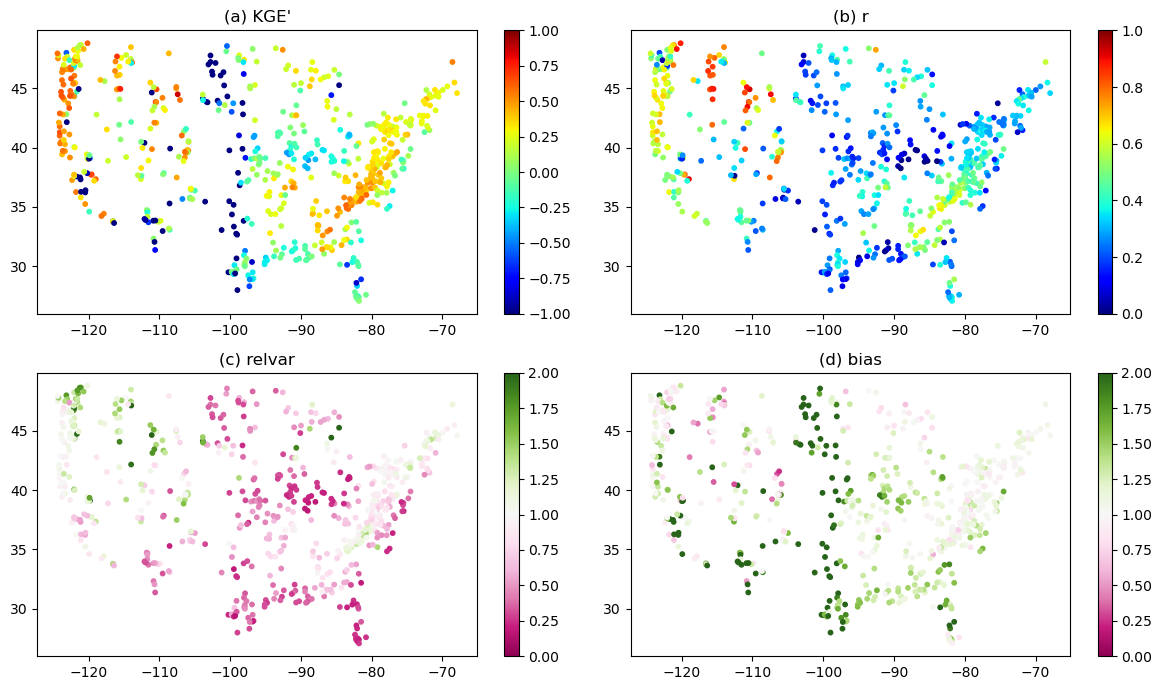

In [26]:
lat = df_info['LAT'].values
lon = df_info['LONG'].values

titles = ["(a) KGE'", '(b) r', '(c) relvar', '(d) bias']
vminvmax = [ [-1, 1], [0, 1], [0, 2], [0, 2] ]
# cmaps = ['cool', 'cool', 'PiYG', 'PiYG']
cmaps = ['jet', 'jet', 'PiYG', 'PiYG']

fig, axs = plt.subplots(2, 2, figsize=[12, 7])
axs = axs.flatten()

for i in range(4):
    ax = axs[i]
    p = ax.scatter(lon, lat, 10, metric_values[:,i], cmap=cmaps[i], vmin=vminvmax[i][0], vmax=vminvmax[i][1], )
    plt.colorbar(p, ax=ax)
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

# Calculate sensitivity

In [27]:
# period = [1950, 2000]
period = [1980, 2013]

In [29]:
# observation

nb = len(df_info)
obs_dQ_v_dT = np.nan * np.zeros(nb)
obs_dQ_v_dP = np.nan * np.zeros(nb)
obs_dQ_v_dPdT = np.nan * np.zeros(nb)

obs_dQ_v_dT_range = np.nan * np.zeros([nb, 2])
obs_dQ_v_dP_range = np.nan * np.zeros([nb, 2])
obs_dQ_v_dPdT_range = np.nan * np.zeros([nb, 2])


for i in range(nb):
    Q = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    # P = ds_obs_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    # T = ds_obs_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_sim_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q) * 100
    dP = (P - np.mean(P)) / np.mean(P) * 100
    dT = T - np.mean(T)
    
    a, b, c, a_interval, b_interval, c_interval = Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10)
    obs_dQ_v_dP[i] = a
    obs_dQ_v_dT[i] = b
    obs_dQ_v_dPdT[i] = c
    obs_dQ_v_dP_range[i] = a_interval
    obs_dQ_v_dT_range[i] = b_interval
    obs_dQ_v_dPdT_range[i] = c_interval


In [30]:
# simulation

nb = len(ds_sim_wy.n)
sim_dQ_v_dT = np.nan * np.zeros(nb)
sim_dQ_v_dP = np.nan * np.zeros(nb)
sim_dQ_v_dPdT = np.nan * np.zeros(nb)

sim_dQ_v_dT_range = np.nan * np.zeros([nb, 2])
sim_dQ_v_dP_range = np.nan * np.zeros([nb, 2])
sim_dQ_v_dPdT_range = np.nan * np.zeros([nb, 2])


for i in range(nb):
    Q = ds_sim_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values.copy()
    P = ds_sim_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    Q2 = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    Q[np.isnan(Q2)] = np.nan
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q) * 100
    dP = (P - np.mean(P)) / np.mean(P) * 100
    dT = T - np.mean(T)
    
    a, b, c, a_interval, b_interval, c_interval = Q_sensitivity_to_P_T(dQ, dP, dT, conflevel=0.10)
    sim_dQ_v_dP[i] = a
    sim_dQ_v_dT[i] = b
    sim_dQ_v_dPdT[i] = c
    sim_dQ_v_dP_range[i] = a_interval
    sim_dQ_v_dT_range[i] = b_interval
    sim_dQ_v_dPdT_range[i] = c_interval

## Is the sensitivity related to accuracy
Short answer is no. No obvious linkage between model accuracy and sensitivity bias. But probably we can try other datasets in addition to NLDAS

In [31]:
def calcualte_robust_cc(a, b):
    # Calculate the 5% and 95% quantile values
    a_5_percentile, a_95_percentile = np.percentile(a, [5, 95])
    b_5_percentile, b_95_percentile = np.percentile(b, [5, 95])

    # Filter data
    index = (a > a_5_percentile) & (a < a_95_percentile) & (b > b_5_percentile) & (b < b_95_percentile) & ~np.isnan(a+b)
    
    a = a[index]
    b = b[index]
    
    pcc = np.corrcoef(a, b)[0,1]
    scc = scipy.stats.spearmanr(a, b).statistic
    
    return pcc, scc
        

In [32]:
bias_dQ_v_dT = np.abs( (sim_dQ_v_dT - obs_dQ_v_dT) / obs_dQ_v_dT )
bias_dQ_v_dP = np.abs( (sim_dQ_v_dP - obs_dQ_v_dP) / obs_dQ_v_dP )
bias_dQ_v_dPdT = np.abs( (sim_dQ_v_dPdT - obs_dQ_v_dPdT) / obs_dQ_v_dPdT )
biasall = [bias_dQ_v_dP, bias_dQ_v_dT, bias_dQ_v_dPdT]

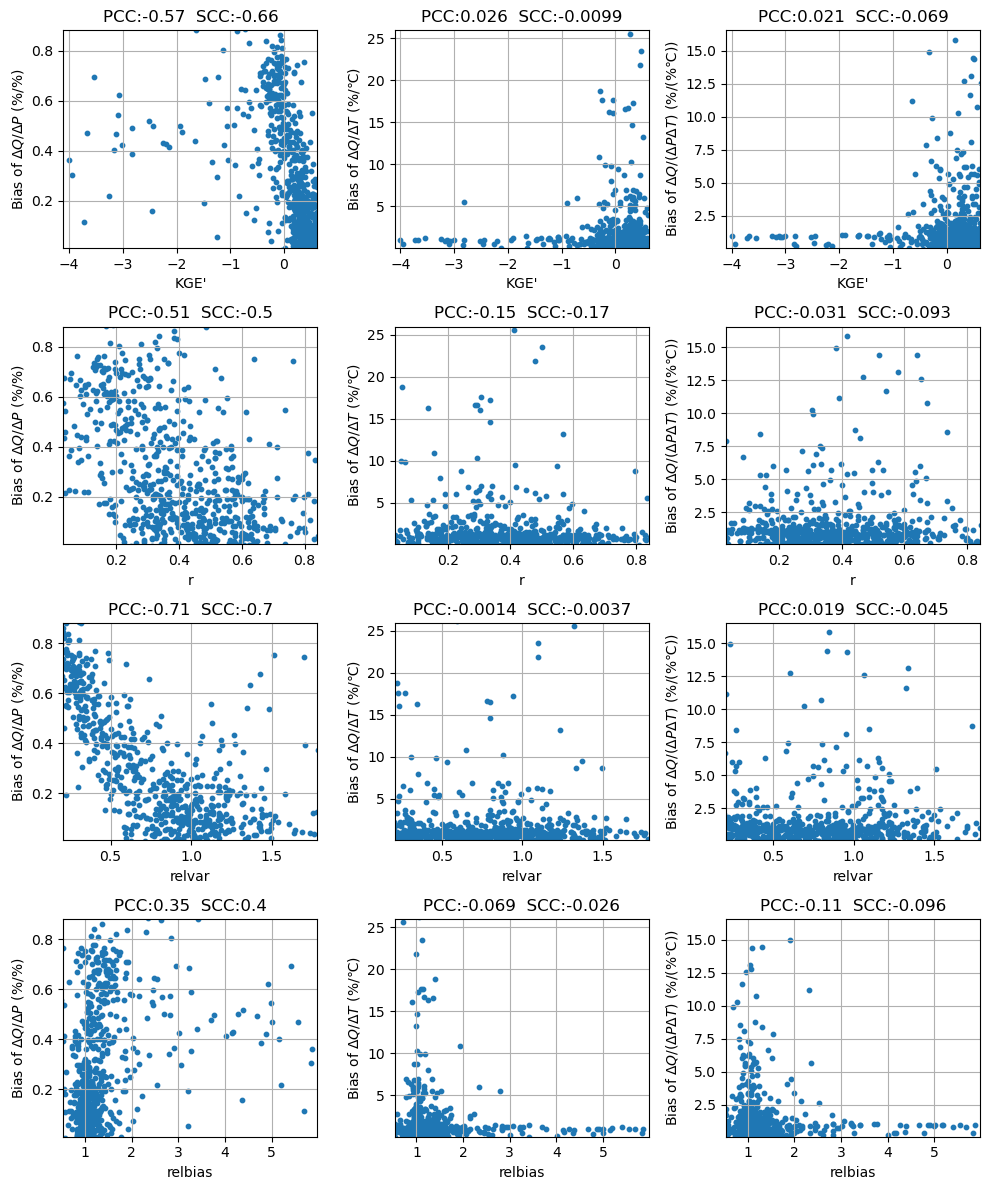

In [33]:
metnames = ["KGE'", "r", "relvar", "relbias"]
sennames = [r"Bias of $\Delta Q /\Delta P$ (%/%)", 
            r"Bias of $\Delta Q /\Delta T$ (%/℃)", 
            r"Bias of $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"]

fig, axs = plt.subplots(4, 3, figsize=[10, 12])

for i in range(4):
    for j in range(3):
        ax = axs[i, j]
        
        ax.scatter(metric_values[:, i], biasall[j], 10)
        ax.set_xlabel(metnames[i])
        ax.set_ylabel(sennames[j])
        
        pcc, scc = calcualte_robust_cc(metric_values[:, i], biasall[j])
        
        s = f'PCC:{pcc:.2}  SCC:{scc:.2}'
        
        ax.set_title(s)
        
        ax.set_xlim(np.percentile(metric_values[:, i], [2, 98]))
        ax.set_ylim(np.percentile(biasall[j], [2, 98]))
        
        ax.grid('on')
            

plt.tight_layout()
plt.show()

# Plot Q vs P/T
Note Obs. and Sim. units are different

In [35]:
# define the true objective function
def objective(x, a, b):
    return a * x + b

## Q VS P/T

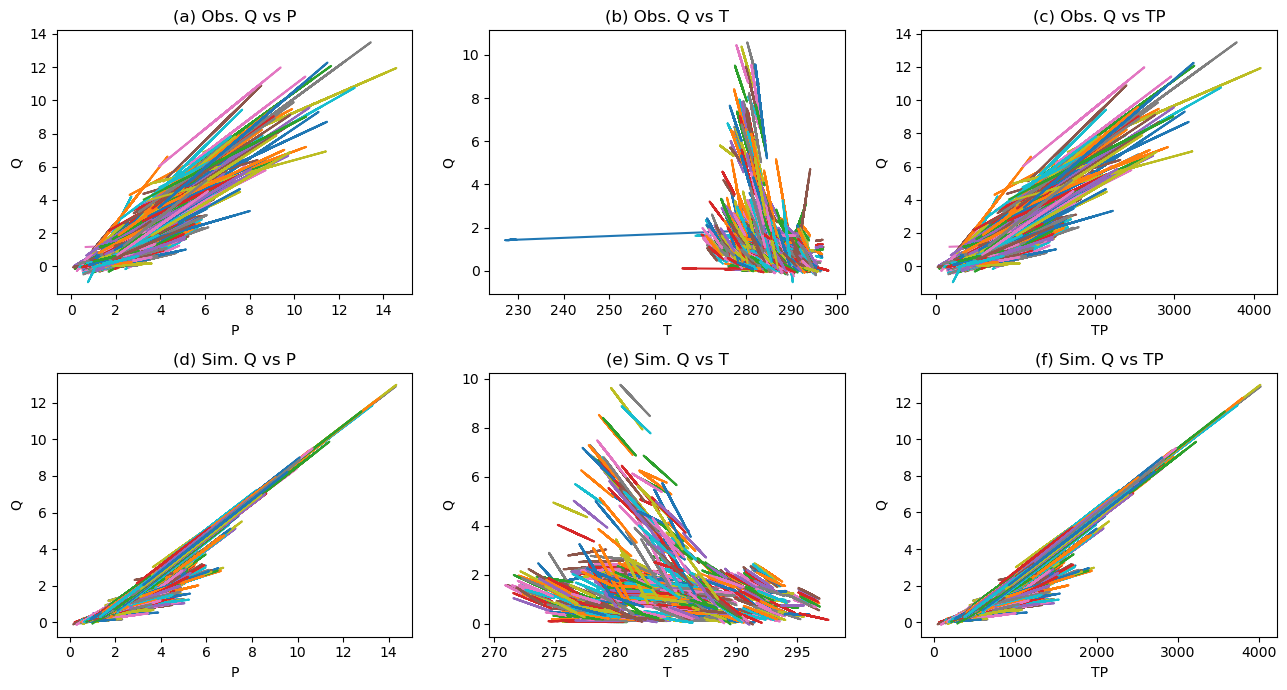

In [36]:

fig, axs = plt.subplots(2, 3, figsize=[13, 7])
period = [1980, 2013]

for i in range(len(ds_obs_wy.n)):
    Q = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_obs_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_obs_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    
    ax = axs[0, 0]
    popt, _ = curve_fit(objective, P, Q)
    a, b = popt
    ax.plot(P, objective(P, a, b))
    ax.set_xlabel('P')
    ax.set_ylabel('Q')
    ax.set_title('(a) Obs. Q vs P')
    
    ax = axs[0, 1]
    popt, _ = curve_fit(objective, T, Q)
    a, b = popt
    ax.plot(T, objective(T, a, b))
    ax.set_xlabel('T')
    ax.set_ylabel('Q')
    ax.set_title('(b) Obs. Q vs T')
    
    ax = axs[0, 2]
    popt, _ = curve_fit(objective, P*T, Q)
    a, b = popt
    ax.plot(P*T, objective(P*T, a, b))
    ax.set_xlabel('TP')
    ax.set_ylabel('Q')
    ax.set_title('(c) Obs. Q vs TP')    
    
    
    
    Q = ds_sim_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_sim_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    ax = axs[1, 0]
    popt, _ = curve_fit(objective, P, Q)
    a, b = popt
    ax.plot(P, objective(P, a, b))
    ax.set_xlabel('P')
    ax.set_ylabel('Q')
    ax.set_title('(d) Sim. Q vs P')
    
    
    ax = axs[1, 1]
    popt, _ = curve_fit(objective, T, Q)
    a, b = popt
    ax.plot(T, objective(T, a, b))
    ax.set_xlabel('T')
    ax.set_ylabel('Q')
    ax.set_title('(e) Sim. Q vs T')
    
    ax = axs[1, 2]
    popt, _ = curve_fit(objective, P*T, Q)
    a, b = popt
    ax.plot(P*T, objective(P*T, a, b))
    ax.set_xlabel('TP')
    ax.set_ylabel('Q')
    ax.set_title('(f) Sim. Q vs TP')      
    
    
plt.tight_layout() 
plt.show()


## dQ vs dP/dT

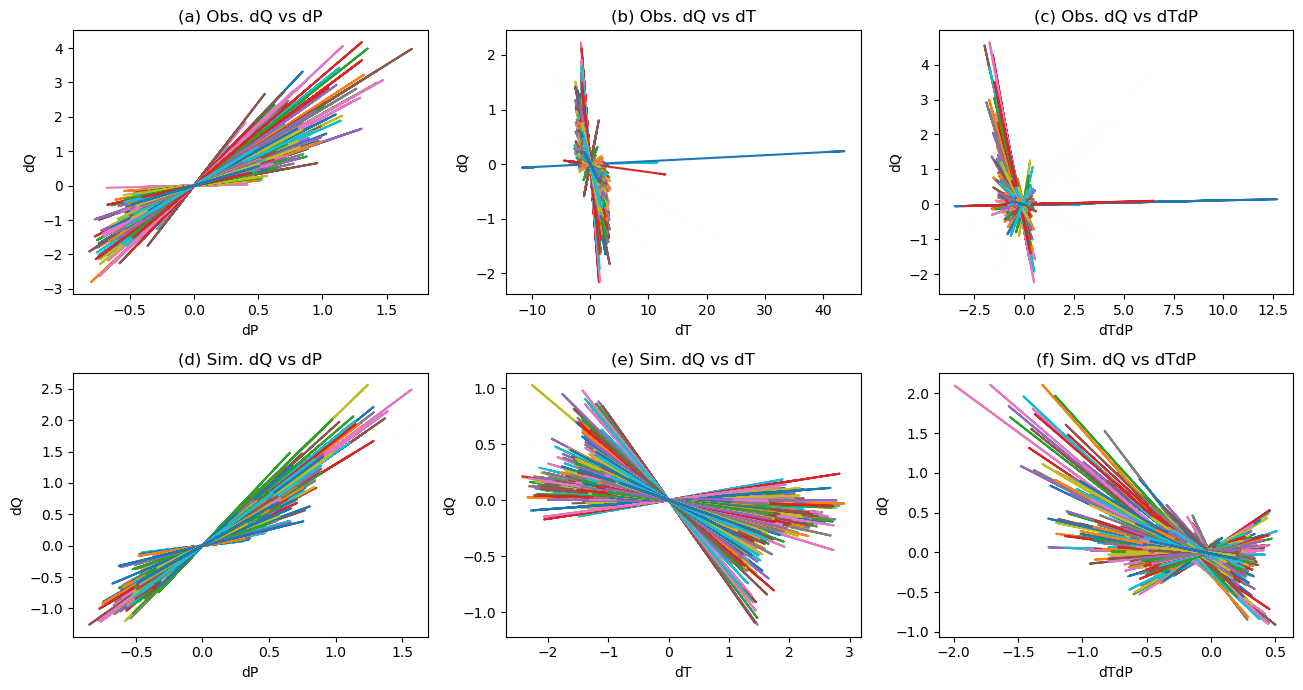

In [37]:

fig, axs = plt.subplots(2, 3, figsize=[13, 7])
period = [1980, 2013]

for i in range(len(ds_obs_wy.n)):
    Q = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_obs_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_obs_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    
    ax = axs[0, 0]
    popt, _ = curve_fit(objective, dP, dQ)
    a, b = popt
    ax.plot(dP, objective(dP, a, b))
    ax.set_xlabel('dP')
    ax.set_ylabel('dQ')
    ax.set_title('(a) Obs. dQ vs dP')
    
    ax = axs[0, 1]
    popt, _ = curve_fit(objective, dT, dQ)
    a, b = popt
    ax.plot(dT, objective(dT, a, b))
    ax.set_xlabel('dT')
    ax.set_ylabel('dQ')
    ax.set_title('(b) Obs. dQ vs dT')
    
    ax = axs[0, 2]
    popt, _ = curve_fit(objective, dP*dT, dQ)
    a, b = popt
    ax.plot(dP*dT, objective(dP*dT, a, b))
    ax.set_xlabel('dTdP')
    ax.set_ylabel('dQ')
    ax.set_title('(c) Obs. dQ vs dTdP')    
    
    
    
    Q = ds_sim_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_sim_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    ax = axs[1, 0]
    popt, _ = curve_fit(objective, dP, dQ)
    a, b = popt
    ax.plot(dP, objective(dP, a, b))
    ax.set_xlabel('dP')
    ax.set_ylabel('dQ')
    ax.set_title('(d) Sim. dQ vs dP')
    
    
    ax = axs[1, 1]
    popt, _ = curve_fit(objective, dT, dQ)
    a, b = popt
    ax.plot(dT, objective(dT, a, b))
    ax.set_xlabel('dT')
    ax.set_ylabel('dQ')
    ax.set_title('(e) Sim. dQ vs dT')
    
    ax = axs[1, 2]
    popt, _ = curve_fit(objective, dP*dT, dQ)
    a, b = popt
    ax.plot(dP*dT, objective(dP*dT, a, b))
    ax.set_xlabel('dTdP')
    ax.set_ylabel('dQ')
    ax.set_title('(f) Sim. dQ vs dTdP')      
    
    
plt.tight_layout() 
plt.show()


## analyze the anomalous basin

In [38]:
for i in range(len(ds_obs_wy.n)):    
    
    Q = ds_sim_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_sim_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    popt, _ = curve_fit(objective, dP, dQ)
    a, b = popt
    
    if a < -1:
        print('anamolous basin', i)
        break
        
df_info.iloc[[i]]

,HUC_02,GAGE_ID,GAGE_NAME,LAT,LONG,DRAINAGE_AREA_(KM^2)
670,17,14400000,CHETCO RIVER NEAR BROOKINGS...,42.12344,-124.18731,702.63


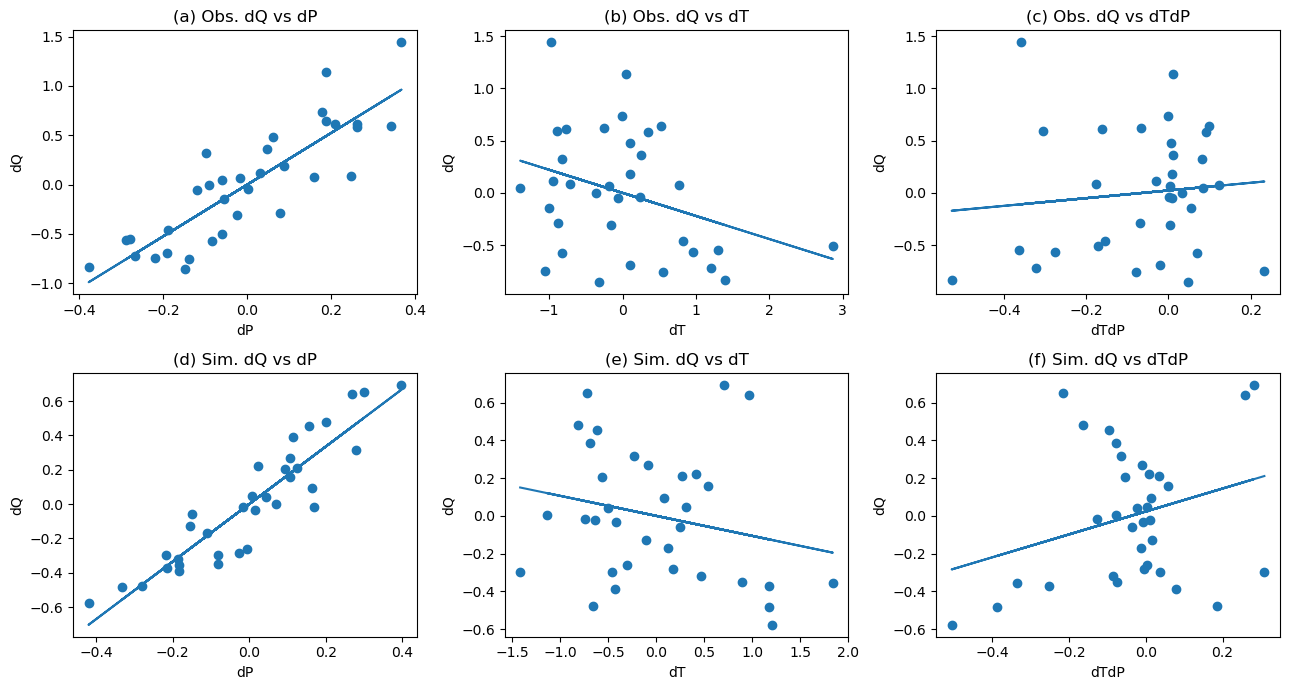

In [39]:

fig, axs = plt.subplots(2, 3, figsize=[13, 7])
period = [1980, 2013]

for i in range(392, 393):
    Q = ds_obs_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_obs_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_obs_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    
    ax = axs[0, 0]
    popt, _ = curve_fit(objective, dP, dQ)
    a, b = popt
    ax.plot(dP, objective(dP, a, b))
    ax.scatter(dP, dQ)
    ax.set_xlabel('dP')
    ax.set_ylabel('dQ')
    ax.set_title('(a) Obs. dQ vs dP')
    
    ax = axs[0, 1]
    popt, _ = curve_fit(objective, dT, dQ)
    a, b = popt
    ax.plot(dT, objective(dT, a, b))
    ax.scatter(dT, dQ)
    ax.set_xlabel('dT')
    ax.set_ylabel('dQ')
    ax.set_title('(b) Obs. dQ vs dT')
    
    ax = axs[0, 2]
    popt, _ = curve_fit(objective, dP*dT, dQ)
    a, b = popt
    ax.plot(dP*dT, objective(dP*dT, a, b))
    ax.scatter(dP*dT, dQ)
    ax.set_xlabel('dTdP')
    ax.set_ylabel('dQ')
    ax.set_title('(c) Obs. dQ vs dTdP')    
    
    
    
    Q = ds_sim_wy['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    P = ds_sim_wy['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    T = ds_sim_wy['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=i).values
    
    indi = ~np.isnan(Q+P+T)
    if np.sum(indi)/len(indi)<0.6:
        print('Warning! Invalid ratio >0.8')
    Q, P, T = Q[indi], P[indi], T[indi]
    
    dQ = (Q - np.mean(Q)) / np.mean(Q)
    dP = (P - np.mean(P)) / np.mean(P)
    dT = T - np.mean(T)
    
    ax = axs[1, 0]
    popt, _ = curve_fit(objective, dP, dQ)
    a, b = popt
    ax.plot(dP, objective(dP, a, b))
    ax.scatter(dP, dQ)
    ax.set_xlabel('dP')
    ax.set_ylabel('dQ')
    ax.set_title('(d) Sim. dQ vs dP')
    
    
    ax = axs[1, 1]
    popt, _ = curve_fit(objective, dT, dQ)
    a, b = popt
    ax.plot(dT, objective(dT, a, b))
    ax.scatter(dT, dQ)
    ax.set_xlabel('dT')
    ax.set_ylabel('dQ')
    ax.set_title('(e) Sim. dQ vs dT')
    
    ax = axs[1, 2]
    popt, _ = curve_fit(objective, dP*dT, dQ)
    a, b = popt
    ax.scatter(dP*dT, dQ)
    ax.plot(dP*dT, objective(dP*dT, a, b))
    ax.set_xlabel('dTdP')
    ax.set_ylabel('dQ')
    ax.set_title('(f) Sim. dQ vs dTdP')      
    
    
plt.tight_layout() 
plt.show()


# Plot sensitivities

## Plot spatial maps

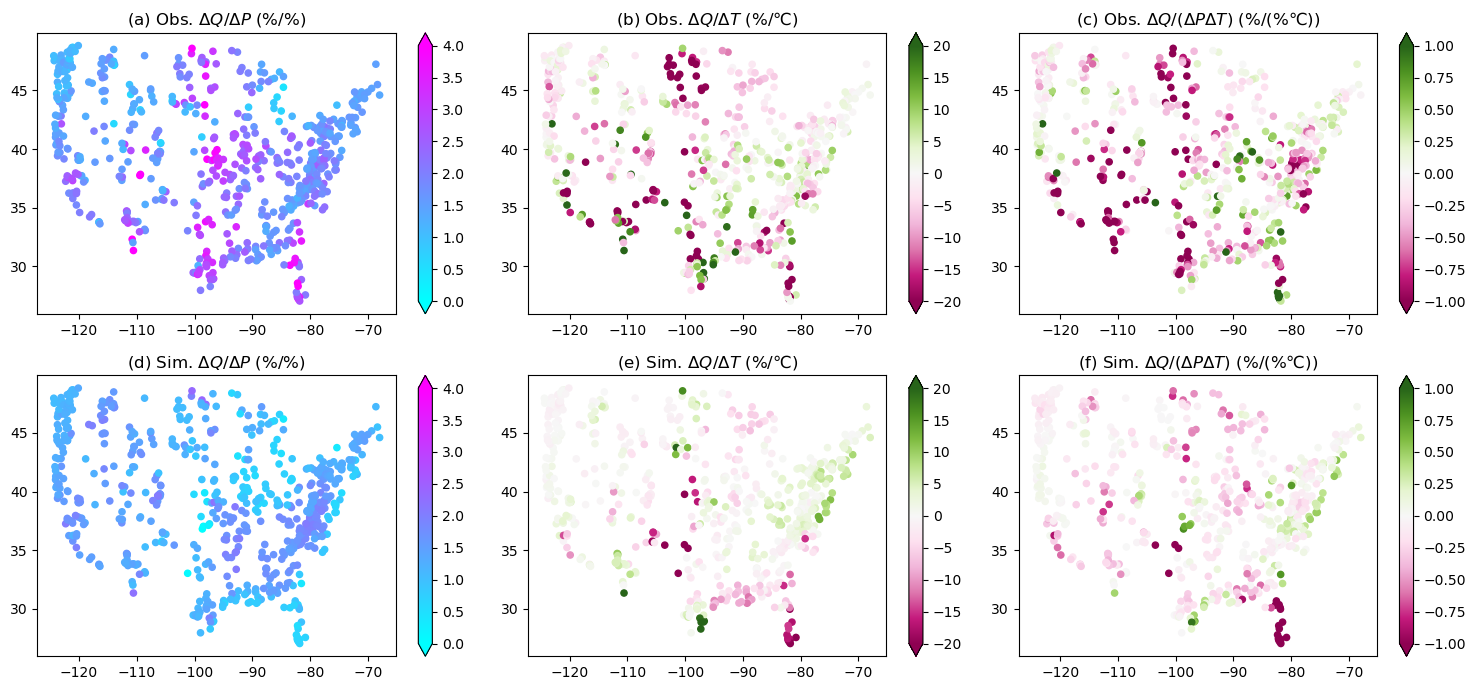

In [40]:
# spatial map

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_dQ_v_dP, sim_dQ_v_dT, sim_dQ_v_dPdT], 
             ]

vminvmax = [ [[0, 4], [-20, 20], [-1, 1]], 
             [[0, 4], [-20, 20], [-1, 1]] ] 
cmaps = [ ['cool', 'PiYG', 'PiYG'], 
         ['cool', 'PiYG', 'PiYG'] ]


lat = df_info['LAT'].values
lon = df_info['LONG'].values
titles = [ [r"(a) Obs. $\Delta Q /\Delta P$ (%/%)", r"(b) Obs. $\Delta Q /\Delta T$ (%/℃)", r"(c) Obs. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"], 
           [r"(d) Sim. $\Delta Q /\Delta P$ (%/%)", r"(e) Sim. $\Delta Q /\Delta T$ (%/℃)", r"(f) Sim. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"] ]

fig, axs = plt.subplots(2, 3, figsize=[15, 7])

for i in range(2):
    for j in range(3):
        ax = axs[i, j]
        
        p = ax.scatter(lon, lat, 20, dataplot[i][j], cmap=cmaps[i][j], vmin=vminvmax[i][j][0], vmax=vminvmax[i][j][1])
        ax.set_title(titles[i][j])

        plt.colorbar(p, ax=ax, extend='both')
    
    
plt.tight_layout()
plt.show()


## Plot confidence invervobs_dQ_v_dPals
Note basins are sorted from low to high sensitivities. Sim and Obs are sorted separately. 

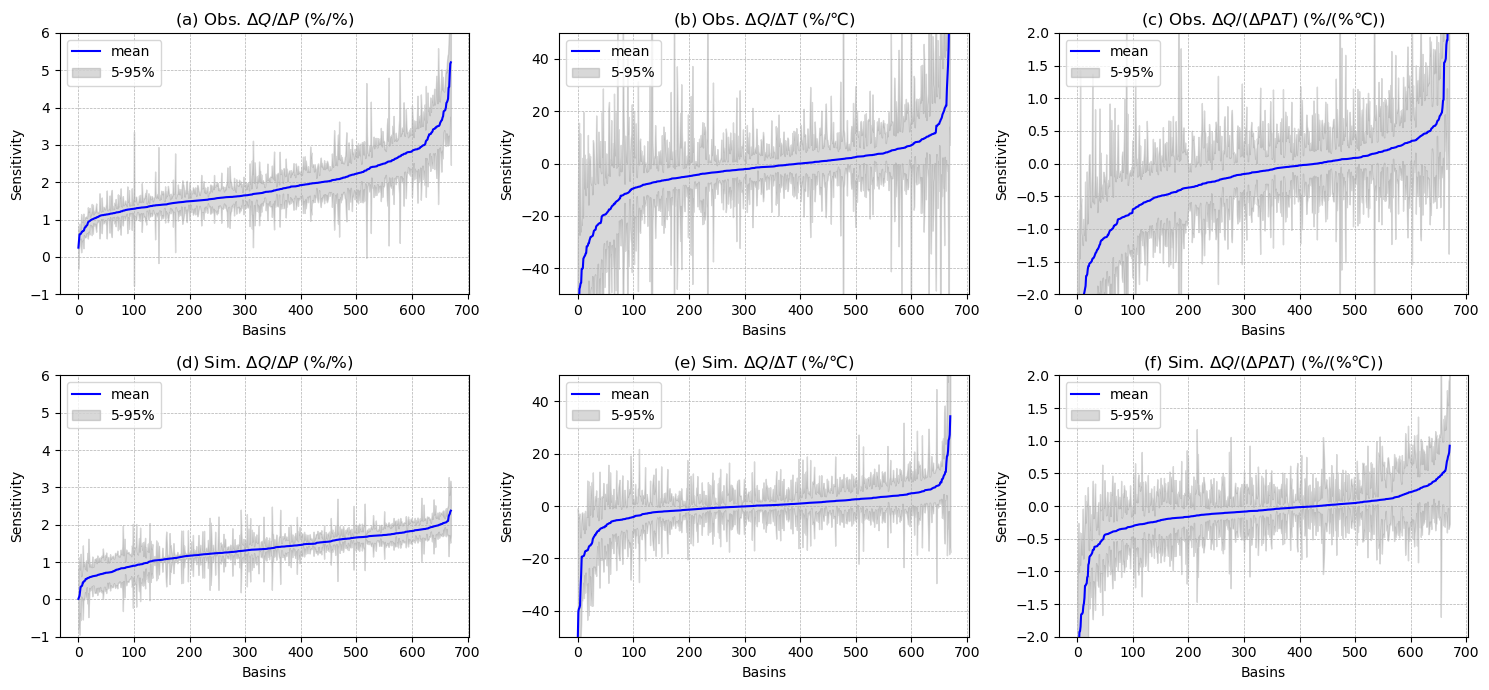

In [41]:
# curve: type-1, separate obs and sim

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_dQ_v_dP, sim_dQ_v_dT, sim_dQ_v_dPdT], 
             ]

datarangeplot = [ [obs_dQ_v_dP_range, obs_dQ_v_dT_range, obs_dQ_v_dPdT_range], 
             [sim_dQ_v_dP_range, sim_dQ_v_dT_range, sim_dQ_v_dPdT_range], 
             ]


vminvmax = [ [[-1, 6], [-50, 50], [-2, 2]], 
             [[-1, 6], [-50, 50], [-2, 2]] ] 


fig, axs = plt.subplots(2, 3, figsize=[15, 7])

for i in range(2):
    for j in range(3):
        ax = axs[i, j]

        data = dataplot[i][j]
        data_range = datarangeplot[i][j]

        # Sort data and create new sorted variables
        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        # Plotting
        ax.plot(range(len(sorted_data)), sorted_data, label="mean", color='blue')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='grey', alpha=0.3, label="5-95%")

        ax.set_title(titles[i][j])
        ax.set_xlabel("Basins")
        ax.set_ylabel("Sensitivity")
        ax.legend(loc='upper left')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        ax.set_ylim(vminvmax[i][j])


plt.tight_layout()
plt.show()

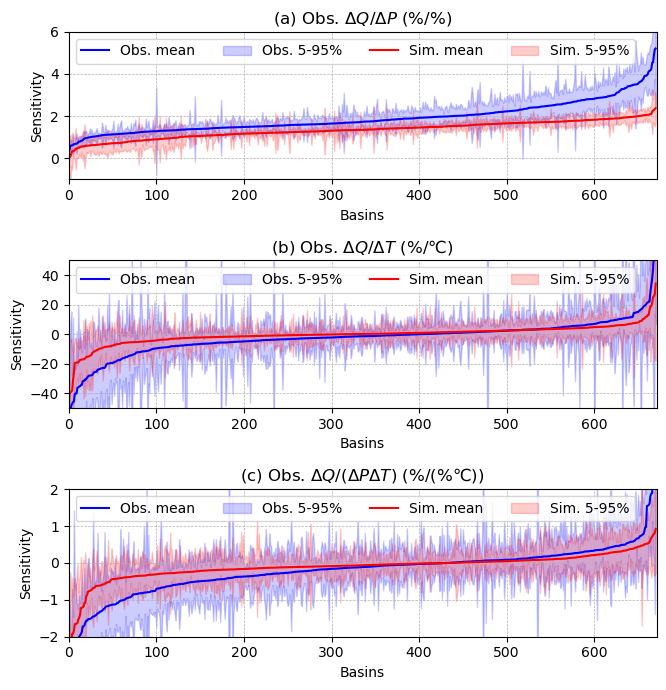

In [42]:
# curve: type-2, obs and sim in same figure

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_dQ_v_dP, sim_dQ_v_dT, sim_dQ_v_dPdT], 
             ]

datarangeplot = [ [obs_dQ_v_dP_range, obs_dQ_v_dT_range, obs_dQ_v_dPdT_range], 
             [sim_dQ_v_dP_range, sim_dQ_v_dT_range, sim_dQ_v_dPdT_range], 
             ]


vminvmax = [ [[-1, 6], [-50, 50], [-2, 2]], 
             [[-1, 6], [-50, 50], [-2, 2]] ] 


fig, axs = plt.subplots(3, 1, figsize=[7, 7])

for i in range(3):
    for j in range(1):
        ax = axs[i]
        
        #obs
        data = dataplot[0][i]
        data_range = datarangeplot[0][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Obs. mean", color='blue')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='blue', alpha=0.2, label="Obs. 5-95%")
        
        #sim
        data = dataplot[1][i]
        data_range = datarangeplot[1][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Sim. mean", color='red')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='red', alpha=0.2, label="Sim. 5-95%")

        ax.set_title(titles[0][i])
        ax.set_xlabel("Basins")
        ax.set_ylabel("Sensitivity")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        
        ax.legend(loc='upper left', ncol=4)
        ax.set_ylim(vminvmax[0][i])
        ax.set_xlim(0, len(data))

plt.tight_layout()
plt.show()

## scatter plots

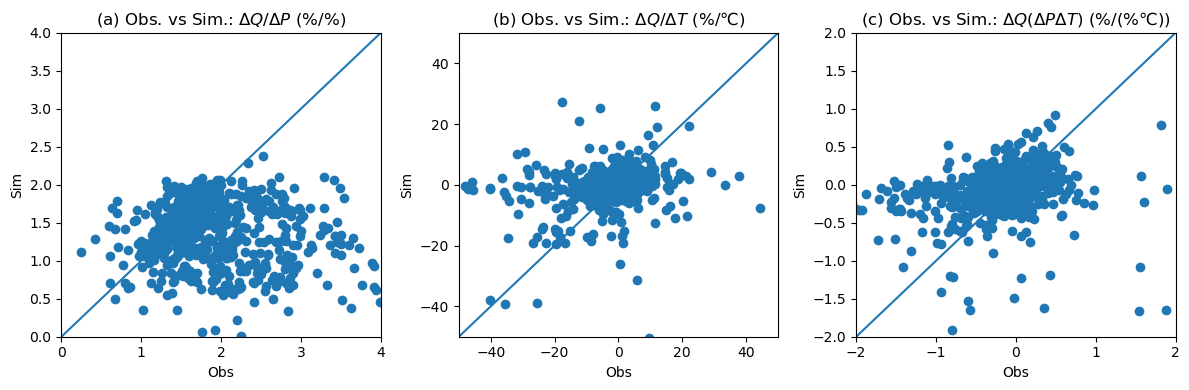

In [43]:
# scatter-1

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_dQ_v_dP, sim_dQ_v_dT, sim_dQ_v_dPdT], 
             ]

vminvmax = [ [0, 4], [-50, 50], [-2, 2] ] 


lat = df_info['LAT'].values
lon = df_info['LONG'].values
titles = [ r"(a) Obs. vs Sim.: $\Delta Q /\Delta P$ (%/%)", r"(b) Obs. vs Sim.: $\Delta Q /\Delta T$ (%/℃)", r"(c) Obs. vs Sim.: $\Delta Q (\Delta P \Delta T)$ (%/(%℃))" ]

fig, axs = plt.subplots(1, 3, figsize=[12, 4])

for i in range(3):
    ax = axs[i]
        
    ax.scatter(dataplot[0][i], dataplot[1][i])
    ax.plot(vminvmax[i], vminvmax[i])
    
    ax.set_title(titles[i])
    
    ax.set_xlim(vminvmax[i])
    ax.set_ylim(vminvmax[i])
    
    ax.set_xlabel('Obs')
    ax.set_ylabel('Sim')
    
    
    
plt.tight_layout()
plt.show()


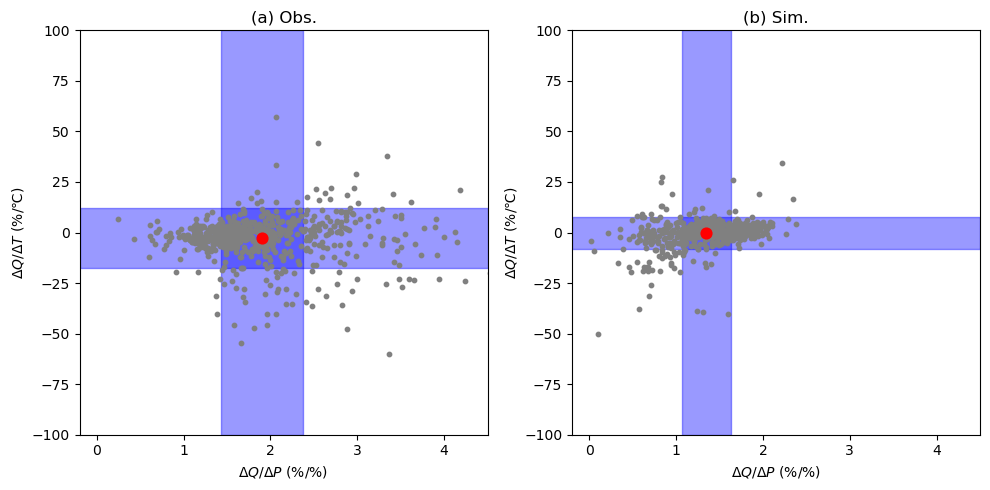

In [44]:
# scatter-2: 
xsc = [obs_dQ_v_dP, sim_dQ_v_dP]
ysc = [obs_dQ_v_dT, sim_dQ_v_dT]
xplot = [np.nanmean(obs_dQ_v_dP), np.nanmean(sim_dQ_v_dP)]
yplot = [np.nanmean(obs_dQ_v_dT), np.nanmean(sim_dQ_v_dT)]
xrangeplot = [ np.nanmean(obs_dQ_v_dP_range, axis=0),  np.nanmean(sim_dQ_v_dP_range, axis=0)]
yrangeplot = [ np.nanmean(obs_dQ_v_dT_range, axis=0), np.nanmean(sim_dQ_v_dT_range, axis=0) ]

titles = ['(a) Obs.', '(b) Sim.']

xlim = [-0.2, 4.5]
ylim = [-100, 100]

fig, axs = plt.subplots(1, 2, figsize=[10, 5])

for i in range(2):
    ax = axs[i]
    
    # plt.fill_between(xrange, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color='b', alpha=0.4)
    ax.fill_between(xrangeplot[i], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='b', alpha=0.4)
    ax.fill_between(xlim, [yrangeplot[i][0], yrangeplot[i][0]], [yrangeplot[i][1], yrangeplot[i][1]], color='b', alpha=0.4)
    ax.scatter(xsc[i], ysc[i], 10, color='grey')
    ax.scatter(xplot[i], yplot[i], 60, color='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(r"$\Delta Q /\Delta T $ (%/℃)")
    ax.set_xlabel(r"$\Delta Q /\Delta P$ (%/%)")
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

# Analyze specific basins

## find a basin to analyze

len of target basins: 0
All basins: []


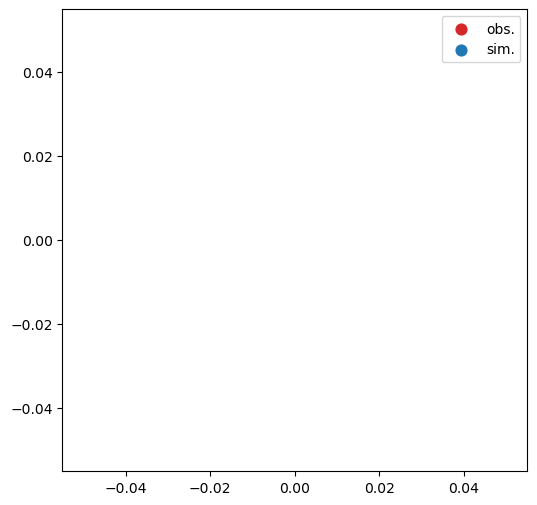

,HUC_02,GAGE_ID,GAGE_NAME,LAT,LONG,DRAINAGE_AREA_(KM^2)


In [45]:
index = np.where( (sim_dQ_v_dP - obs_dQ_v_dP > 1) & (sim_dQ_v_dT - obs_dQ_v_dT > 10) )[0]
print('len of target basins:', len(index))
print('All basins:', index)

fig, ax = plt.subplots(figsize=[6, 6])
plt.scatter(obs_dQ_v_dP[index], obs_dQ_v_dT[index], 60, color='tab:red', label='obs.')
plt.scatter(sim_dQ_v_dP[index], sim_dQ_v_dT[index], 60, color='tab:blue', label='sim.')
for i in range(len(index)):
    plt.plot([obs_dQ_v_dP[index[i]], sim_dQ_v_dP[index[i]]], [obs_dQ_v_dT[index[i]], sim_dQ_v_dT[index[i]]], color='grey', linewidth=1)
    plt.text(obs_dQ_v_dP[index[i]]+0.05, obs_dQ_v_dT[index[i]]+0.5, index[i], color='red')

plt.legend()
plt.show()

df_info.iloc[index]

## Analyze the target basin

In [46]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

def plot_QPT_series(ds_obs_wy, ds_sim_wy, basintar, period):

    # plot Q, P, and T time series
    # period = [1980, 2013]

    fig, axs = plt.subplots(3, 1, figsize=[8, 8])

    v = ['Q', 'P', 'T']
    titles = ['(a) Runoff', '(b) Precipitation', '(c) Air temperature']
    labs = ['Q (mm/day)', 'P (mm/day)', 'T (K)']
    

    for i in range(3):

        ax = axs[i]
        ds_obs_wy[v[i]].isel(n=basintar).sel(time=slice(str(period[0]), str(period[1]))).plot(ax=ax, marker='o', color='tab:red', label='Obs.')
        ds_sim_wy[v[i]].isel(n=basintar).sel(time=slice(str(period[0]), str(period[1]))).plot(ax=ax, marker='s', color='tab:blue', label='Sim.')
        ax.legend(loc='upper left')

        ax.set_title(titles[i])
        ax.set_xlabel('')
        ax.set_ylabel(labs[i])

    plt.tight_layout()
    plt.show()
    

def plot_dQdPdT_scatter(ds_obs_wy, ds_sim_wy, basintar, period):
    
    # plot dQ vs dP, dT

    fig, axs = plt.subplots(2, 2, figsize=[8, 8])

    ds = [ds_obs_wy, ds_sim_wy]
    labs = ['Obs.', 'Sim.']
    colors = ['tab:red', 'tab:blue']

    for i in range(2):

        Q = ds[i]['Q'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=basintar).values
        P = ds[i]['P'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=basintar).values
        T = ds[i]['T'].sel(time=slice(str(period[0]), str(period[1]))).isel(n=basintar).values

        indi = ~np.isnan(Q+P+T)
        if np.sum(indi)/len(indi)<0.6:
            print('Warning! Invalid ratio >0.8')
        Q, P, T = Q[indi], P[indi], T[indi]

        dQ = (Q - np.mean(Q)) / np.mean(Q)
        dP = (P - np.mean(P)) / np.mean(P)
        dT = T - np.mean(T)

        ax = axs[0, 0]
        ax.scatter(P, Q, color=colors[i], label=labs[i])
        popt, _ = curve_fit(objective, P, Q)
        a, b = popt
        ax.plot(P, objective(P, a, b), color=colors[i])
        ax.set_xlabel('P (mm/d)')
        ax.set_ylabel('Q (mm/d)')
        ax.set_title('(a) Q vs P')
        ax.legend(loc='upper left')


        ax = axs[0, 1]
        ax.scatter(T, Q, color=colors[i], label=labs[i])   
        popt, _ = curve_fit(objective, T, Q)
        a, b = popt
        ax.plot(T, objective(T, a, b), color=colors[i])
        ax.set_xlabel('T (K)')
        ax.set_ylabel('Q (mm/d)')
        ax.set_title('(a) Q vs T')
        ax.legend(loc='upper left')


        ax = axs[1, 0]
        ax.scatter(dP, dQ, color=colors[i], label=labs[i])
        
        # p1,p2 = np.percentile(dP, [5, 95])
        # q1,q2 = np.percentile(dQ, [5, 95])
        # induse = (dP>=p1) & (dP<=p2) & (dQ>=q1) & (dQ<=q2)
        # popt, _ = curve_fit(objective, dP[induse], dQ[induse])
        # print(popt)
        
        popt, _ = curve_fit(objective, dP, dQ)
        a, b = popt
        ax.plot(dP, objective(dP, a, b), color=colors[i])
        ax.set_xlabel('dP (%)')
        ax.set_ylabel('dQ (%)')
        ax.set_title(r'(c) $\Delta Q$ vs $\Delta P$')
        ax.legend(loc='upper left')


        ax = axs[1, 1]
        ax.scatter(dT, dQ, color=colors[i], label=labs[i])   
        popt, _ = curve_fit(objective, dT, dQ)
        a, b = popt
        ax.plot(dT, objective(dT, a, b), color=colors[i])
        ax.set_xlabel('dT (K)')
        ax.set_ylabel('dQ (%)')
        ax.set_title(r'(d) $\Delta Q$ vs $\Delta T$')
        ax.legend(loc='upper left')



    plt.tight_layout()
    plt.show()

### basin-1
Temperature bias to runoff bias?

##################################################
Basin info
HUC_02                                                                 10
GAGE_ID                                                           6876700
GAGE_NAME                                                SALT C NR ADA...
LAT                                                              39.13907
LONG                                                            -97.83696
DRAINAGE_AREA_(KM^2)                                              1056.44
Name: 380, dtype: object
##################################################
Shapefile area


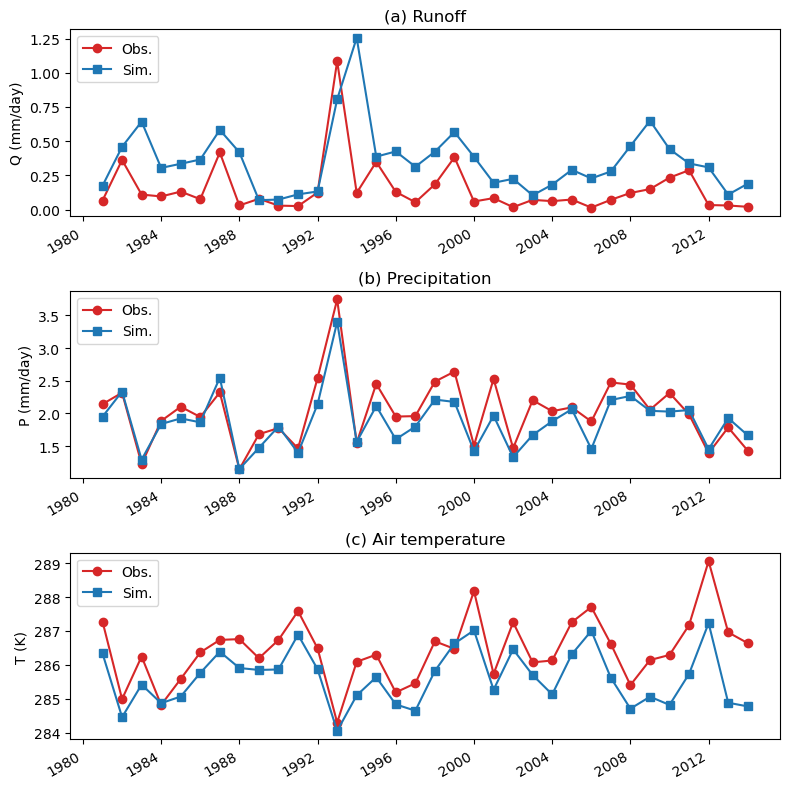

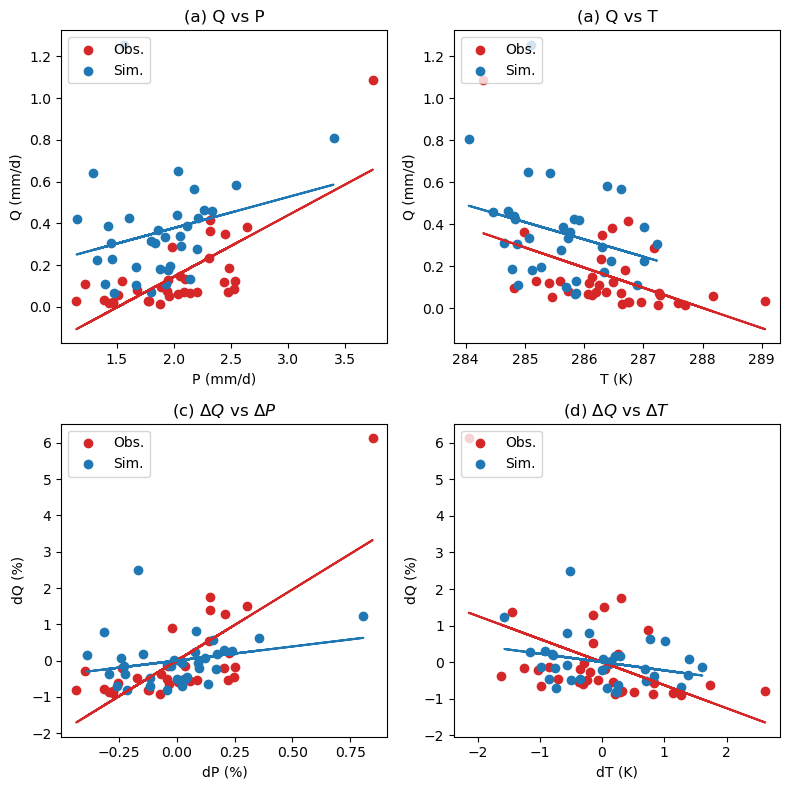

In [47]:
basintar = 380
print('#'*50)
print('Basin info')
print(df_info.iloc[basintar])
print('#'*50)
print('Shapefile area')
# print(shp_camels.loc[shp_camels['hru_id']==df_info.iloc[basintar]['GAGE_ID']]['AREA']/1e6)

period = [1980, 2013]
plot_QPT_series(ds_obs_wy, ds_sim_wy, basintar, period)
plot_dQdPdT_scatter(ds_obs_wy, ds_sim_wy, basintar, period)

### basin-2
It does not seem that CTSM does something obvious wrong for this basin. The sensitivity difference is probably mainly caused by temperature.  
Higher resolution forcing may help?

##################################################
Basin info
HUC_02                                                                  7
GAGE_ID                                                           5454000
GAGE_NAME                                   Rapid Creek near Iowa City...
LAT                                                              41.70002
LONG                                                            -91.48767
DRAINAGE_AREA_(KM^2)                                                65.38
Name: 305, dtype: object
##################################################
Shapefile area


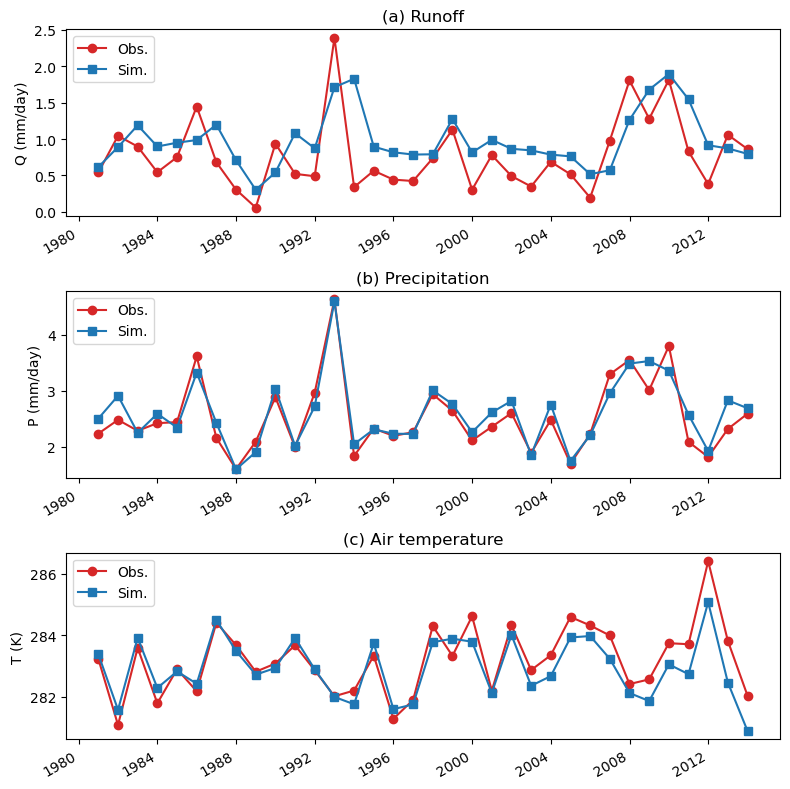

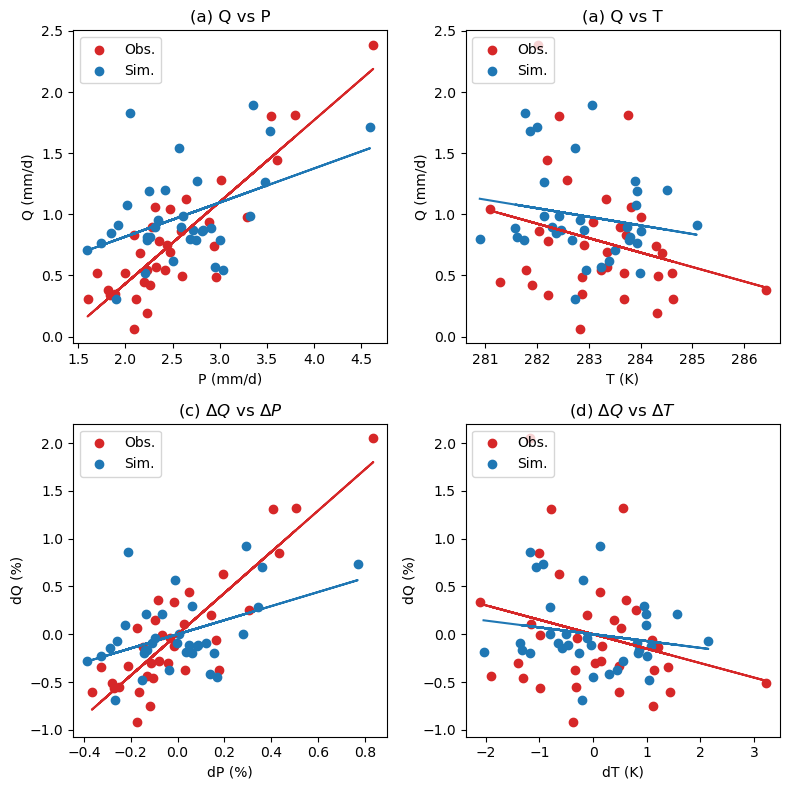

In [48]:
basintar = 305
print('#'*50)
print('Basin info')
print(df_info.iloc[basintar])
print('#'*50)
print('Shapefile area')
# print(shp_camels.loc[shp_camels['hru_id']==df_info.iloc[basintar]['GAGE_ID']]['AREA']/1e6)

period = [1980, 2013]
plot_QPT_series(ds_obs_wy, ds_sim_wy, basintar, period)
plot_dQdPdT_scatter(ds_obs_wy, ds_sim_wy, basintar, period)